In [95]:
import csv
import math as m
from random import uniform as unif
import networkx as nx

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
expid = "./exp1_run1"

In [97]:
if not os.path.exists(expid):
    os.makedirs(expid)

# Problem instance

## Raw data

In [98]:
# locations
xy_customers = list(csv.reader(
    open('./datasets/original/xy_customers.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

xy_icps = list(csv.reader(
    open('./datasets/original/xy_icps.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

xy_crcs = list(csv.reader(
    open('./datasets/original/xy_crcs.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

xy_pc = [100.0,60.0]

# product return
Uq = list(csv.reader(
    open('./datasets/original/U.csv'),delimiter=' ',
    quoting=csv.QUOTE_NONNUMERIC))

In [99]:
xy_icps = xy_icps + [[unif(20,100),unif(20,70)] for i in range(10)]
xy_crcs = xy_crcs + [[unif(20,100),unif(20,70)] for i in range(5)]

## Data pre-processing

In [100]:
# index
I = len(xy_customers)
J = len(xy_icps)
C = len(xy_crcs)

In [101]:
# distance cost
W = [[m.sqrt((cus[0]-icp[0])**2 + (cus[1]-icp[1])**2) for icp in xy_icps] for cus in xy_customers]
D = [[m.sqrt((icp[0]-crc[0])**2 + (icp[1]-crc[1])**2) for crc in xy_crcs] for icp in xy_icps ]
L = [m.sqrt((xy_pc[0]-crc[0])**2 + (xy_pc[1]-crc[1])**2) for crc in xy_crcs]

In [102]:
DL = [[D[j][c]+L[c] for c in range(C)] for j in range(J)]

In [103]:
# fixed setup cost
FCT = [100 for i in range(J)]
FCR = [200 for i in range(C)]

In [104]:
# Demand and capacity
U = []
for i in range(I):
    U.append(Uq[0][i] + Uq[1][i] + Uq[2][i])
    
Q = [200 for j in range(J)]
V = [[200 for j in range(J)],[800 for c in range(C)]]

In [105]:
# two-level cost
c = [[[W[i][j1] + DL[j1][j2] for j2 in range(C)] for j1 in range(J)] for i in range(I)]
f = FCT+FCR

# Plot Problem

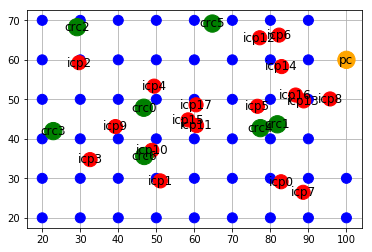

In [106]:
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
G, pos, labels, colors, size = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs, xy_pc)

lrp_draw_and_save(G, pos, labels, colors, size, expid+"/problem.png")

# Define Functions

## run_uflp_cplex

In [107]:
def run_uflp_cplex(G,I,J,W,FCT,expid):
    from pkg.uflp_cplex import uflp_cplex

    prob, Y, N_icp = uflp_cplex(I,J,
                W,FCT,
                relaxation=False,path=expid+"/uflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/uflp_cplex.png")

## run_cflp_cplex

In [108]:
def run_cflp_cplex(G,I,J,W,FCT,U,Q,expid):
    from pkg.cflp_cplex import cflp_cplex

    prob, Y, N_icp = cflp_cplex(I,J,
                W,FCT,U,Q,
                relaxation=False,path=expid+"/cflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/cflp_cplex.png")

## run_tuflp_cplex

In [109]:
def run_tuflp_cplex(G,I,J,C,c,f,expid):
    from pkg.tuflp_cplex import tuflp_cplex

    prob, X, Z = tuflp_cplex(I,J,C,c,f,
                relaxation=False,path=expid+"/tcflp_cplex.lp")


    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tcflp_cplex.png")

## run_tecflp_cplex

In [110]:
def run_tecflp_cplex(G,I,J,C,c,f,q,V,expid):
    from pkg.tecflp_cplex import tecflp_cplex

    prob, X, Z = tecflp_cplex(I,J,C,c,f,q,V,
                relaxation=False,path=expid+"/tecflp_cplex.lp")

    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tecflp_cplex.png")

# Run experiment

Default row names c1, c2 ... being created.


Found incumbent of value 1989.529822 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.59 ticks)
Probing time = 0.02 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (2.57 ticks)
Probing time = 0.00 sec. (0.90 ticks)
Clique table members: 950.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (1.86 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1989.5298        0.0000           100.00%
*     0+    0                        

Default row names c1, c2 ... being created.


Found incumbent of value 1989.529822 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.59 ticks)
Probing time = 0.00 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.57 ticks)
Probing time = 0.00 sec. (0.90 ticks)
Clique table members: 950.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (1.86 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1989.5298        0.0000           100.00%
*     0+    0                        

Default row names c1, c2 ... being created.


Found incumbent of value 1989.529822 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.59 ticks)
Probing time = 0.00 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.57 ticks)
Probing time = 0.01 sec. (0.90 ticks)
Clique table members: 950.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (1.86 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1989.5298        0.0000           100.00%
*     0+    0                        

Default row names c1, c2 ... being created.


Found incumbent of value 1989.529822 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.59 ticks)
Probing time = 0.01 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 950 rows, 918 columns, and 2700 nonzeros.
Reduced MIP has 918 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.57 ticks)
Probing time = 0.00 sec. (0.90 ticks)
Clique table members: 950.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (1.86 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1989.5298        0.0000           100.00%
*     0+    0                        

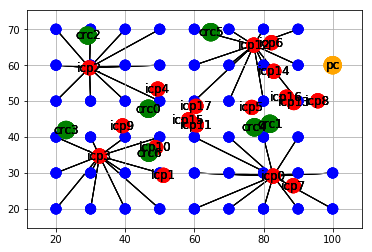

In [111]:
result1 = %timeit -o run_uflp_cplex(G,I,J,W,FCT,expid)

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 32 rows and 576 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.02 ticks)
Found incumbent of value 2957.246332 after 0.03 sec. (2.02 ticks)
Probing time = 0.02 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.58 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Clique table members: 342.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                    

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 32 rows and 576 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.02 ticks)
Found incumbent of value 2957.246332 after 0.02 sec. (2.02 ticks)
Probing time = 0.02 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.58 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Clique table members: 342.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                    

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 32 rows and 576 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.02 ticks)
Found incumbent of value 2957.246332 after 0.02 sec. (2.02 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.58 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Clique table members: 342.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                    

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve eliminated 32 rows and 576 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.02 ticks)
Found incumbent of value 2957.246332 after 0.02 sec. (2.02 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 36 rows, 342 columns, and 666 nonzeros.
Reduced MIP has 342 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.58 ticks)
Probing time = 0.00 sec. (0.47 ticks)
Clique table members: 342.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                    

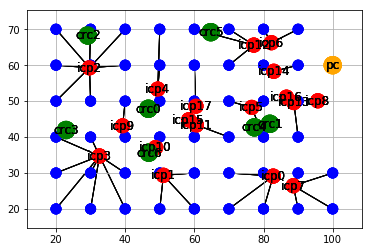

In [112]:
result2 = %timeit -o run_cflp_cplex(G,I,J,W,FCT,U,Q,expid)

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (17.16 ticks)
Found incumbent of value 5564.254762 after 0.11 sec. (20.34 ticks)
Probing time = 0.05 sec. (4.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (17.11 ticks)
Probing time = 0.09 sec. (4.19 ticks)
Clique table members: 1300.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.06 sec. (6.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5564.2548        0.0000           100.00%
*     0+    0            

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (17.16 ticks)
Found incumbent of value 5564.254762 after 0.11 sec. (20.34 ticks)
Probing time = 0.14 sec. (4.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (17.11 ticks)
Probing time = 0.09 sec. (4.19 ticks)
Clique table members: 1300.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.05 sec. (6.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5564.2548        0.0000           100.00%
*     0+    0            

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (17.16 ticks)
Found incumbent of value 5564.254762 after 0.09 sec. (20.34 ticks)
Probing time = 0.09 sec. (4.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (17.11 ticks)
Probing time = 0.11 sec. (4.19 ticks)
Clique table members: 1300.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.06 sec. (6.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5564.2548        0.0000           100.00%
*     0+    0            

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (17.16 ticks)
Found incumbent of value 5564.254762 after 0.06 sec. (20.34 ticks)
Probing time = 0.19 sec. (4.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 1300 rows, 6325 columns, and 20150 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (17.11 ticks)
Probing time = 0.06 sec. (4.19 ticks)
Clique table members: 1300.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (6.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5564.2548        0.0000           100.00%
*     0+    0            

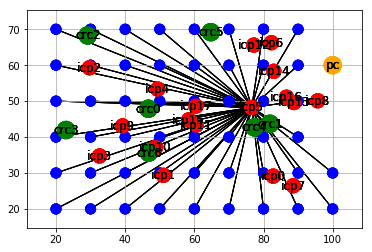

In [113]:
result3 = %timeit -o run_tuflp_cplex(G,I,J,C,c,f,expid)

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve modified 25 coefficients.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (8.22 ticks)
Found incumbent of value 9600.868169 after 0.14 sec. (23.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (7.95 ticks)
Probing time = 0.03 sec. (3.57 ticks)
Clique table members: 12650.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.05 sec. (7.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         9600.8682        0.0000           100.00%
*     0+    0                

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve modified 25 coefficients.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (8.22 ticks)
Found incumbent of value 9600.868169 after 0.05 sec. (23.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.95 ticks)
Probing time = 0.13 sec. (3.57 ticks)
Clique table members: 12650.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (7.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         9600.8682        0.0000           100.00%
*     0+    0                

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve modified 25 coefficients.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (8.22 ticks)
Found incumbent of value 9600.868169 after 0.12 sec. (23.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (7.95 ticks)
Probing time = 0.28 sec. (3.57 ticks)
Clique table members: 12650.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.06 sec. (7.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         9600.8682        0.0000           100.00%
*     0+    0                

Default row names c1, c2 ... being created.


Tried aggregator 1 time.
MIP Presolve modified 25 coefficients.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (8.22 ticks)
Found incumbent of value 9600.868169 after 0.05 sec. (23.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 75 rows, 6325 columns, and 18925 nonzeros.
Reduced MIP has 6325 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.95 ticks)
Probing time = 0.19 sec. (3.57 ticks)
Clique table members: 12650.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.01 sec. (7.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         9600.8682        0.0000           100.00%
*     0+    0                

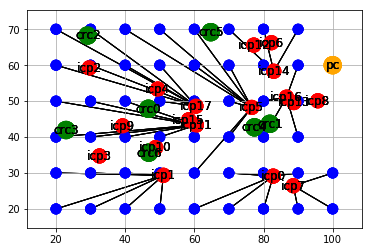

In [114]:
result4 = %timeit -o run_tecflp_cplex(G,I,J,C,c,f,U,V,expid)

## Results

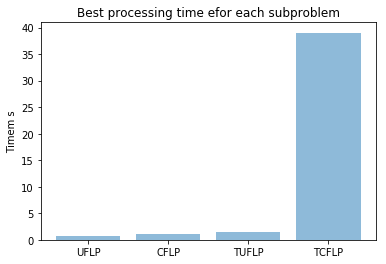

In [115]:
objects = ('UFLP', 'CFLP', 'TUFLP', 'TCFLP')
y_pos = np.arange(len(objects))
performance = [result1.best,result2.best,result3.best,result4.best]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time s')
plt.title('Best processing time for each subproblem')
 
plt.show()